In [25]:
%load_ext autoreload
%autoreload 2
import os
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
import numpy as np
from copy import deepcopy
import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import pandas as pd
import joblib
# from mprompt.config import RESULTS_DIR
import torch.cuda
import json
from sklearn.linear_model import RidgeCV
import pandas as pd
import re
import sklearn.decomposition
import pyLDAvis
import pyLDAvis.lda_model
import numpy as np
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import adjustText
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
import os
from os.path import join
from tqdm import tqdm
from InstructorEmbedding import INSTRUCTOR

RESULTS_DIR = '/home/chansingh/mprompt/results'
# df = pd.read_csv(join(RESULTS_DIR, 'bert', "dict_learn_results - extracted factors_all.csv"))
expls_scores_bert = joblib.load(join(RESULTS_DIR, 'bert', 'wiki_norm_std', 'wiki_our_syn_perc_std_score.pkl'))

# BERT_RAW_RESULTS_DIR = '/home/chansingh/mntv1/aliyah/ah-module-prompt/results/'
# for layer in tqdm(range(13)):
#     layer_dir = f'dl_l{layer}'
#     for factor in range(1500):
#         factor_dir = f'i{factor}'
#         extra_dir = os.listdir(join(BERT_RAW_RESULTS_DIR, layer_dir, factor_dir))[0]
#         results = joblib.load(join(BERT_RAW_RESULTS_DIR, layer_dir, factor_dir, extra_dir, 'results.pkl'))
#         expl = results['top_explanation_init_strs']
#         expls.append(expl)
# joblib.dump(join(RESULTS_DIR, 'bert', 'expls_bert.jbl'))
expls_bert = joblib.load(join(RESULTS_DIR, 'bert', 'expls_bert.jbl'))


df_f = pd.read_pickle(join(RESULTS_DIR, 'results_fmri_full.pkl'))
expls_fmri = df_f['top_explanation_init_strs'].values.tolist()

df_bert = pd.DataFrame.from_dict({
    'layer': sum([[i] * 1500 for i in range(13)], []),
    'score': expls_scores_bert.flatten(),
    'expl': expls_bert,
})
df_fmri = pd.DataFrame.from_dict({
    'layer': 'fmri',
    'score': df_f['top_score_synthetic'].values,
    'expl': expls_fmri,
})

# filter dfs
df_bert = df_bert[df_bert['score'] > 1]
df_fmri = df_fmri[df_fmri['score'] > 0]
n_bert = len(df_bert)
expls = df_bert['expl'].values.tolist() + df_fmri['expl'].values.tolist()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Embeddings Viz

In [ ]:
# get embeddings
embeddor = INSTRUCTOR('hkunlp/instructor-xl')
instruction = "Represent the short phrase for clustering:"
embs = embeddor.encode([[instruction, x_i] for x_i in expls], batch_size=32)
# tsne = TSNE(n_components=2, random_state=42, verbose=False)
# word_vectors_2d = tsne.fit_transform(embs)
pca = sklearn.decomposition.PCA(n_components=2)
word_vectors_2d = pca.fit_transform(embs)
df_bert['x'] = word_vectors_2d[:, 0][:n_bert]
df_bert['y'] = word_vectors_2d[:, 1][:n_bert]
df_fmri['x'] = word_vectors_2d[:, 0][n_bert:]
df_fmri['y'] = word_vectors_2d[:, 1][n_bert:]

In [ ]:
def plot_tsne(df_bert, df_fmri, hue='layer', label_map_dict=None, adjust_text=True):
    for lay in sorted(df_bert[hue].unique()):
        df_plot_lay = df_bert[df_bert[hue] == lay]
        if hue == 'layer':
            label = f"Layer {lay}"
        elif hue == 'topic_num':
            label = label_map_dict[lay]
        plt.plot(
            df_plot_lay['x'],
            df_plot_lay['y'],
            marker=".",
            alpha=0.25,
            # markersize=1,
            label=label,
            color=sns.color_palette("viridis_r", 26)[lay],
            linestyle="None",
        )

    plt.plot(
            df_fmri['x'],
            df_fmri['y'],
            marker=".",
            alpha=1,
            # markersize=1,
            label=f"fMRI",
            color='pink',
            linestyle="None",
        )
    texts = []
    for i, word in enumerate(df_bert['expl']):
        if i % 50 == 0:
            texts.append(
                plt.annotate(word[:15], (word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize='xx-small'))
    for i, word in enumerate(df_fmri['expl']):
        if i % 50 == 0:
            texts.append(
                plt.annotate(word[:15], (word_vectors_2d[n_bert + i, 0], word_vectors_2d[n_bert + i, 1]), fontsize='xx-small'))

    # make texts not overlap
    if adjust_text:
        print('adjusting texts...')
        adjustText.adjust_text(texts) #, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))

    plt.xlabel("PC dimension 1")
    plt.ylabel("PC dimension 2")
    

plt.figure(figsize=(15, 12))
plot_tsne(df_bert, df_fmri, adjust_text=True)
plt.legend(bbox_to_anchor=(1.1, 0.9))
plt.savefig(join(RESULTS_DIR, 'bert', 'tsne_unrestricted.png'), dpi=300, bbox_inches='tight')

# LDAVis

In [26]:
# Preprocessing: remove numbers, special characters, and lowercase all words
processed_docs = [re.sub(r"[^\w\s]", "", doc.lower()) for doc in expls]

# Vectorize the text data
vectorizer = CountVectorizer(stop_words="english", max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(processed_docs)
dtm_bert = dtm[:n_bert]

# LDA model - only fitting to BERT!!!
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Visualize clusters using PyLDAVis
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='tsne')
# pyLDAvis.save_html(vis, join(RESULTS_DIR, 'bert', 'lda.html'))

# add topics to df
words = vectorizer.get_feature_names_out()
topic_names_dict = {
    topic_idx: f"{topic_idx + 1}: "
    + ", ".join([words[i] for i in topic.argsort()[:-8:-1]])
    for topic_idx, topic in enumerate(lda.components_)
}
print(topic_names_dict)
topics = lda.transform(dtm).argmax(axis=1)
df_bert["topic_num"] = topics[:n_bert]
df_fmri["topic_num"] = topics[n_bert:]

{0: '1: verb, form, military, specifically, measurements, naval, architecture', 1: '2: technology, related, music, andor, education, activities, science', 2: '3: people, places, things, names, end, military, letter', 3: '4: action, movement, relationships, physical, communication, family, idea', 4: '5: time, dates, preposition, different, mathematics, past, type', 5: '6: sports, physical, activity, locations, media, objects, action', 6: '7: word, end, contain, followed, number, phrase, noun', 7: '8: history, culture, concept, numbers, way, language, nouns', 8: '9: words, time, phrases, location, specific, movement, period', 9: '10: specific, type, year, place, person, government, particular'}


### Barplot

/tmp/ipykernel_2588379/1817605982.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(
/tmp/ipykernel_2588379/1817605982.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(
/tmp/ipykernel_2588379/1817605982.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


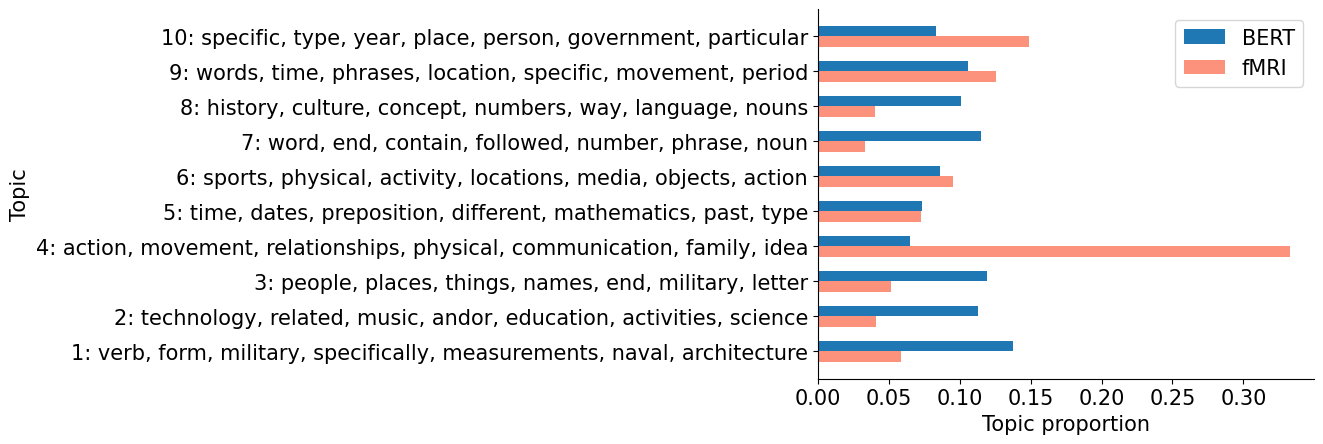

In [32]:
# df_bert_lower = df_bert[:int(n_bert * (1/13))]
# df_bert_upper = df_bert[int(n_bert * (12/13)):]

counts = pd.merge(
    (df_bert["topic_num"].value_counts() / len(df_bert)).reset_index(),
    (df_fmri["topic_num"].value_counts() / len(df_fmri)).reset_index(),
    # (df_bert_lower["topic_num"].value_counts() / len(df_bert_lower)).reset_index(),
    # (df_bert_upper["topic_num"].value_counts() / len(df_bert_upper)).reset_index(), 
    on="topic_num",
).rename(columns={"count_x": "bert", "count_y": "fmri"})

# make barplot from counts df with 'bert' and 'fmri' as the legend and topic_num as the ylabel
plt.barh(
    counts["topic_num"] + 0.15, counts["bert"], color="C0", label="BERT", height=0.3
)
plt.barh(
    counts["topic_num"] - 0.15,
    counts["fmri"],
    # color=(0.74073277, 0.38723941, 0.3813074),
    # color= (0.9344867358708189, 0.2286812764321415, 0.17139561707035755),
    # color = (0.9882352941176471, 0.732072279892349, 0.6299269511726259),
    color='#fc917c',
    label="fMRI",
    height=0.3,
)
plt.yticks(counts["topic_num"], labels=counts["topic_num"].map(topic_names_dict))
plt.xlabel("Topic proportion")
plt.ylabel("Topic")
plt.legend()
plt.savefig(
    join(RESULTS_DIR, "bert", "topic_proportions.png"), dpi=300, bbox_inches="tight"
)
plt.savefig(
    join(RESULTS_DIR, "bert", "topic_proportions.pdf"), dpi=300, bbox_inches="tight"
)

### Barplot by layer

In [24]:
counts = pd.merge(
    (df_bert['topic_num'].value_counts() / len(df_bert)).reset_index(),
    (df_fmri['topic_num'].value_counts() / len(df_fmri)).reset_index(),
    on='topic_num',
).rename(columns={'count_x': 'bert', 'count_y': 'fmri'})

# make barplot from counts df with 'bert' and 'fmri' as the legend and topic_num as the ylabel
plt.barh(counts['topic_num'] - 0.15, counts['bert'], color ='C0', label='BERT', height=0.3)
plt.barh(counts['topic_num'] + 0.15, counts['fmri'], color='pink', label='fMRI', height=0.3)
plt.yticks(counts['topic_num'], labels=counts['topic_num'].map(topic_names_dict))
plt.xlabel('Topic proportion')
plt.ylabel('Topic')
plt.legend()
plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.png'), dpi=300, bbox_inches='tight')
plt.savefig(join(RESULTS_DIR, 'bert', 'topic_proportions.pdf'), dpi=300, bbox_inches='tight')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py:3652 in  │
│ get_loc                                                                                          │
│                                                                                                  │
│   3649 │   │   """                                                                               │
│   3650 │   │   casted_key = self._maybe_cast_indexer(key)                                        │
│   3651 │   │   try:                                                                              │
│ ❱ 3652 │   │   │   return self._engine.get_loc(casted_key)                                       │
│   3653 │   │   except KeyError as err:                                                           │
│   3654 │   │   │   raise KeyError(key) from err                                                  │
│   3655 │   │   except TypeError:                                                                 │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:147                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:176                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7080                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7088                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'topic_num'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 counts = pd.merge(                                                                          │
│ ❱  2 │   (df_bert['topic_num'].value_counts() / len(df_bert)).reset_index(),                     │
│    3 │   (df_fmri['topic_num'].value_counts() / len(df_fmri)).reset_index(),                     │
│    4 │   on='topic_num',                                                                         │
│    5 ).rename(columns={'count_x': 'bert', 'count_y': 'fmri'})                                    │
│                                                                                                  │
│ /home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pandas/core/frame.py:3760 in         │
│ __getitem__                                                                                      │
│                                                                                                  │
│    3757 │   │   if is_single_key:                                                                │
│    3758 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3759 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3760 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3761 │   │   │   if is_integer(indexer):                                                      │
│    3762 │   │   │   │   indexer = [indexer]                                                      │
│    3763 │   │   else:                                              

### Boxplot

In [ ]:
coefs = lda.transform(dtm)
coefs_bert = coefs[:n_bert].T
coefs_fmri = coefs[n_bert:].T

# sns.set_theme(style="ticks")
df_bert_box = pd.DataFrame.from_dict({
    'topic': sum([[f'Topic {i}'] * coefs_bert.shape[1] for i in range(coefs_bert.shape[0])], []),
    'coef': coefs_bert.flatten(),
    'source': 'BERT',
})
df_fmri_box = pd.DataFrame.from_dict({
    'topic': sum([[f'Topic {i}'] * coefs_fmri.shape[1] for i in range(coefs_fmri.shape[0])], []),
    'coef': coefs_fmri.flatten(),
    'source': 'fMRI',
})
df_box = pd.concat([df_bert_box, df_fmri_box])
# df = df_bert
f, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.boxplot(x="coef", y="topic", data=df_box,
            width=.6, palette="vlag", whis=[0, 100], hue='source')
# , whis=0, fliersize=0)
plt.xlim(0, 0.1)

# Add in points to show each observation
# sns.stripplot(x="coef", y="topic", data=df,
            #   size=2, color=".5", linewidth=0, alpha=0.1, hue='source',)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.xlabel("Topic coefficient")
plt.show()
# plt.savefig(join(RESULTS_DIR, 'bert', 'wiki_normalized_syn_scores', 'wiki_our_syn_perc_score_boxplot.png'))

In [ ]:
plt.figure(figsize=(20, 12))
plot_tsne(
    df_bert,
    df_fmri,
    hue="topic_num",
    label_map_dict=topic_names_dict,
    adjust_text=False,
)
plt.legend(bbox_to_anchor=(1.1, 0.9), fontsize='xx-small')